In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
import time

from math import *

from torchvision.transforms.functional import rotate

import pygame

DEVICE = "cuda"

pygame 2.1.2 (SDL 2.0.16, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [182]:
NUM_AGENTS = 16
NUM_STATES = 3
NUM_PERCEPTIONS = 16
NUM_ACTIONS = 2
RADIUS = 16
RES = 64

def to_plt(img, detach=True): 
    return img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() if detach \
        else img.squeeze(0).permute(1, 2, 0).cpu().numpy()


class RadConv(nn.Module):
    def __init__(self, NI, NO, radius):
        super().__init__()
        self.conv = nn.Conv2d(NI, NO, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        
        avg_weight = t.zeros_like(self.conv.weight.data)
        
        for theta in np.arange(0,2*pi,pi/64.0):
            avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/pi)/128.0
        # for theta in np.arange(0,2*t.pi,t.pi/256.0):
        #     avg_weight += rotate(self.conv.weight.data.detach().clone(), 180*theta/t.pi)/np.sqrt(512.0)
                    
        self.conv.weight.data = np.pi*avg_weight
    
    def forward(self, x):
        return self.conv(x)
        
class SimpleConvNet(nn.Module):
    def __init__(self, NI, NO = 1, radius=3):

        super().__init__()
        
        self.conv = RadConv(NI, NO, radius)
        # self.conv = nn.Conv2d(NI, NO, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        self.relu = nn.ReLU()
        self.thresh = nn.Threshold(0.5, 0)
        self.sigmoid = nn.Sigmoid()
        self.glu = nn.GLU()
        

    def forward(self, x):
        x = self.conv(x)
        # x = self.relu(x)
        # x = self.sigmoid(x)
        # x = self.thresh(x)
        # x = t.clamp(x, 0, 1)
        x = t.heaviside((x - 0.5*t.min(x)), t.cuda.FloatTensor([0]))
        return x        

In [183]:
positions = t.randint(RES, (NUM_AGENTS, 2)).cuda()
directions = t.randint(2, (NUM_AGENTS, 2)).cuda()
speeds = t.randint(1, 1+RES//32, (NUM_AGENTS, 1)).cuda()
states = t.randint(255, (NUM_AGENTS, 3)).cuda()
perceptions = t.rand((NUM_AGENTS, NUM_PERCEPTIONS)).cuda()
# positions, directions, speeds, states, perceptions
directions, speeds, directions*speeds, positions

(tensor([[1, 1],
         [1, 1],
         [1, 0],
         [1, 0],
         [0, 1],
         [1, 1],
         [1, 1],
         [0, 0],
         [1, 1],
         [0, 0],
         [0, 0],
         [1, 0],
         [0, 0],
         [1, 0],
         [0, 1],
         [0, 1]], device='cuda:0'),
 tensor([[2],
         [1],
         [2],
         [2],
         [2],
         [1],
         [1],
         [1],
         [1],
         [1],
         [2],
         [1],
         [2],
         [1],
         [1],
         [2]], device='cuda:0'),
 tensor([[2, 2],
         [1, 1],
         [2, 0],
         [2, 0],
         [0, 2],
         [1, 1],
         [1, 1],
         [0, 0],
         [1, 1],
         [0, 0],
         [0, 0],
         [1, 0],
         [0, 0],
         [1, 0],
         [0, 1],
         [0, 2]], device='cuda:0'),
 tensor([[ 1, 13],
         [56, 54],
         [62, 17],
         [20,  7],
         [ 0, 48],
         [41, 38],
         [23, 23],
         [49, 13],
         [29, 39],
    

In [184]:
# positions = t.randint(RES, (1, 2)).cuda()
# positions[0], positions[0, :], positions[0, 0], positions[0, 1]

In [185]:
# world = t.zeros((1, 3, RES, RES), dtype=t.long).cuda()
# world[0, :, 10, 10] = states[0]

In [186]:
# world[0, :, 10, 10]

In [187]:
world = t.zeros((1, 3, RES, RES), dtype=t.long)
for i in range(NUM_AGENTS):
    state = states[i].cpu(); print(state)
    x_i = positions[i, 0].cpu().numpy()
    y_i = positions[i, 1].cpu().numpy()
    print(x_i, y_i, state)
    world[0, :, x_i, y_i] = state
    # world[0, 1, positions[i, 0], positions[i, 1]] = directions[i, 0]
    # world[0, 2, positions[i, 0], positions[i, 1]] = directions[i, 1]


tensor([109, 190, 140])
1 13 tensor([109, 190, 140])
tensor([ 91,  24, 147])
56 54 tensor([ 91,  24, 147])
tensor([147, 217, 124])
62 17 tensor([147, 217, 124])
tensor([ 43, 232, 101])
20 7 tensor([ 43, 232, 101])
tensor([ 44, 171,  42])
0 48 tensor([ 44, 171,  42])
tensor([162,  73,  80])
41 38 tensor([162,  73,  80])
tensor([ 69,  82, 100])
23 23 tensor([ 69,  82, 100])
tensor([  7, 127, 226])
49 13 tensor([  7, 127, 226])
tensor([46, 73, 46])
29 39 tensor([46, 73, 46])
tensor([134,  65,  10])
43 34 tensor([134,  65,  10])
tensor([ 42, 153, 127])
63 21 tensor([ 42, 153, 127])
tensor([173, 137, 181])
40 50 tensor([173, 137, 181])
tensor([133,  79, 168])
31 0 tensor([133,  79, 168])
tensor([246, 239, 112])
18 21 tensor([246, 239, 112])
tensor([229, 250,  73])
40 19 tensor([229, 250,  73])
tensor([156, 113,  96])
37 54 tensor([156, 113,  96])


In [188]:
world[0, :, 50, 31]    

tensor([0, 0, 0])

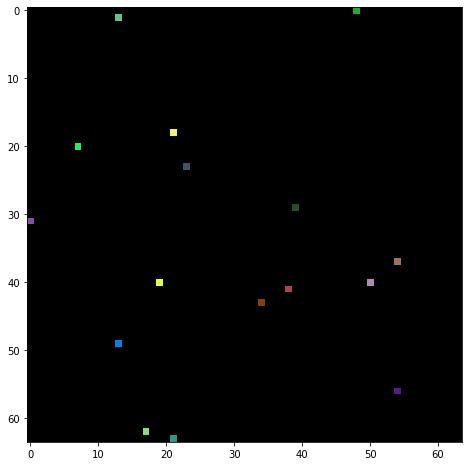

In [189]:
f, axs = plt.subplots(1,figsize=(8,8))
axs.imshow(to_plt(world))

In [190]:
to_plt(world).shape

avg_pool = F.adaptive_avg_pool2d(world.type(t.cuda.FloatTensor), (1, 1)).squeeze(3).squeeze(2)
avg_pool, avg_pool.shape


(tensor([[0.4470, 0.5432, 0.4329]], device='cuda:0'), torch.Size([1, 3]))

In [191]:
avg_pool.shape

torch.Size([1, 3])

In [192]:
    

class Agent(nn.Module):
    
    def __init__(self, env, position = t.cuda.LongTensor(np.random.randint(RES, size=2)), action = t.cuda.FloatTensor(np.random.randint(1, RES//32, size=2)), state = t.rand(1, NUM_STATES).cuda(), perception = t.rand(1, NUM_PERCEPTIONS).cuda()):
        super().__init__()
        self.env = env
        self.position = position; print(self.position.shape); print(position); 
        self.action = action; print(self.action.shape)
        self.state = state; print(self.state.shape)
        self.perception = perception; print(self.perception.shape)
        self.perceptive_field = None

        # self.action = action.view(-1, 1); print(self.action.shape)
        # self.state = state.view(-1, 1); print(self.state.shape)
        # self.perception = perception.view(-1, 1); print(self.perception.shape)
        self.config = t.cat([self.perception.view(-1, NUM_PERCEPTIONS), self.state.view(-1, NUM_STATES), self.action.view(-1, NUM_ACTIONS)], dim = 1).cuda(); #print(self.config.shape)
        
        self.env.world[0, :, self.position[0, 0], self.position[0, 1]] = self.config
        self.env.states[0, :, self.position[0, 0], self.position[0, 1]] = self.state
        
        # self.config = t.cat([self.perception, self.state, self.action], dim = 1); print(self.config.shape)
        self.P = RadConv(NI = NUM_PERCEPTIONS+NUM_STATES+NUM_ACTIONS, NO = NUM_PERCEPTIONS, radius = RADIUS).cuda(); #things in the environment; other agents states, their perception etc; NUM_AGENTS x NUM_STATES x NUM_PERCEPTIONS
        self.max_pool = lambda x: F.adaptive_max_pool2d(x.type(t.cuda.FloatTensor), (1, 1)).cuda().squeeze(3).squeeze(2)
        # self.conv = nn.Conv2d(NUM_AGENTS*NUM_PERCEPTIONS*NUM_STATES, NUM_PERCEPTIONS*NUM_STATES, 2*radius+1, padding=radius, padding_mode='circular', bias=None)
        # self.S = nn.Linear(RES*RES*(NUM_PERCEPTIONS), NUM_STATES, bias=False).cuda()
        # self.A = nn.Linear(RES*RES*(NUM_PERCEPTIONS), NUM_ACTIONS, bias=False).cuda()
        self.S = nn.Linear(NUM_PERCEPTIONS, NUM_STATES, bias=False).cuda()
        self.A = nn.Linear(NUM_PERCEPTIONS, NUM_ACTIONS, bias=False).cuda()

        # self.fc3 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_STATES)
        # self.fc4 = nn.Linear(NUM_PERCEPTIONS+NUM_STATES, NUM_ACTIONS)

    def forward(self, world):
        
        perceptive_field = self.P(world); 
        self.perceptive_field = perceptive_field
        self.perception = self.max_pool(perceptive_field); print("perception: ", self.perception, self.perception.shape)
        self.state = self.S(self.perception); print("state: ", self.state); print(self.state.shape)
        self.action = self.A(self.perception).type(t.cuda.LongTensor); print(self.action); print(self.action.shape)
        
        #update position
        self.position = (self.position + self.action) % RES; print(self.position); print(self.position.shape)
        #update config
        self.config = t.tensor(t.cat([self.perception, self.state, self.action], dim=1)).cuda(); print(self.config); print(self.config.shape)

        self.env.world[0, :, self.position[0, 0], self.position[0, 1]] = self.config
        self.env.states[0, :, self.position[0, 0], self.position[0, 1]] = self.state
        
        return self.config

In [193]:
class Environment(nn.Module):
    def __init__(self, num_agents = NUM_AGENTS, num_states = NUM_STATES, num_perceptions = NUM_PERCEPTIONS, num_actions = NUM_ACTIONS, radius = RADIUS, size = RES):
        super(Environment, self).__init__()
        
        self.num_agents = num_agents
        # self.agents = [Agent(self) for i in range(num_agents)]
        self.num_states = num_states
        self.num_perceptions = num_perceptions
        self.num_actions = num_actions
        self.radius = radius
        self.size = size

        self.world = t.zeros((1, num_perceptions+num_states+num_actions, size, size), dtype=t.float).cuda() 
        self.states = t.zeros((1, num_states, size, size), dtype=t.float).cuda() 

        self.agents = []
        self.add_agents()
        
    def add_agents(self, num_agents = None):
        if num_agents is None:
            num_agents = self.num_agents
        for i in range(num_agents):    
            position = t.randint(RES, (1, 2)).cuda()
            direction = t.randint(2, (1, 2)).cuda()
            speed = t.randint(1, 1+RES//32, (1, 1)).cuda()
            state = t.randint(255, (1, 3)).cuda()
            perception = t.rand((1, NUM_PERCEPTIONS)).cuda()
            action = direction*speeds
            self.agents.append(Agent(self, position = position, action = direction*speed, state = state, perception = perception))

    @property
    def positions(self):
        return [a.position for a in self.agents]

    def update(self, x = None):
    
        self.world = t.zeros((1, self.num_perceptions+self.num_states+self.num_actions, self.size, self.size), dtype=t.float).cuda() 
        self.states = t.zeros((1, self.num_states, self.size, self.size), dtype=t.float).cuda() 
        
        for agent in self.agents:
            agent.forward(self.world)

    def forward(self):
        return self.update()

In [194]:
E = Environment().cuda()
# a = Agent(E).cuda()


torch.Size([1, 2])
tensor([[53, 48]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[63, 37]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[20, 50]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[15, 17]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[60, 20]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[36, 29]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[38, 12]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[63,  0]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
torch.Size([1, 16])
torch.Size([1, 2])
tensor([[47,  9]], device='cuda:0')
torch.Size([1, 2])
torch.Size([1, 3])
tor

In [195]:
E.positions

[tensor([[53, 48]], device='cuda:0'),
 tensor([[63, 37]], device='cuda:0'),
 tensor([[20, 50]], device='cuda:0'),
 tensor([[15, 17]], device='cuda:0'),
 tensor([[60, 20]], device='cuda:0'),
 tensor([[36, 29]], device='cuda:0'),
 tensor([[38, 12]], device='cuda:0'),
 tensor([[63,  0]], device='cuda:0'),
 tensor([[47,  9]], device='cuda:0'),
 tensor([[20,  8]], device='cuda:0'),
 tensor([[18, 21]], device='cuda:0'),
 tensor([[63, 16]], device='cuda:0'),
 tensor([[61, 37]], device='cuda:0'),
 tensor([[12, 41]], device='cuda:0'),
 tensor([[14, 62]], device='cuda:0'),
 tensor([[23,  2]], device='cuda:0')]

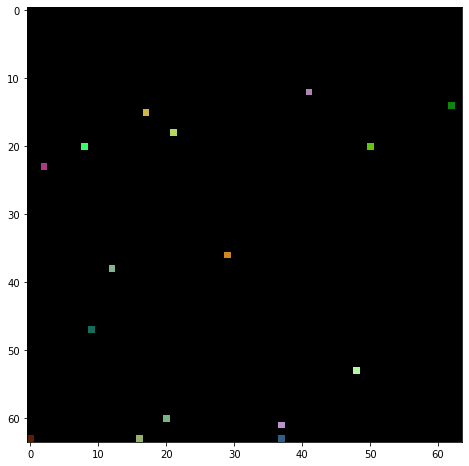

In [196]:
f, axs = plt.subplots(1,figsize=(8,8))
axs.imshow(to_plt(E.states).astype(np.uint8))

perception:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<SqueezeBackward1>) torch.Size([1, 16])
state:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 3])
tensor([[0, 0]], device='cuda:0')
torch.Size([1, 2])
tensor([[53, 48]], device='cuda:0')
torch.Size([1, 2])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
torch.Size([1, 21])
perception:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<SqueezeBackward1>) torch.Size([1, 16])
state:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 3])
tensor([[0, 0]], device='cuda:0')
torch.Size([1, 2])
tensor([[63, 37]], device='cuda:0')
torch.Size([1, 2])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
torch.Size([1, 21])
percep

/tmp/ipykernel_1506568/1700001880.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.config = t.tensor(t.cat([self.perception, self.state, self.action], dim=1)).cuda(); print(self.config); print(self.config.shape)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
torch.Size([1, 21])
perception:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<SqueezeBackward1>) torch.Size([1, 16])
state:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 3])
tensor([[0, 0]], device='cuda:0')
torch.Size([1, 2])
tensor([[63,  0]], device='cuda:0')
torch.Size([1, 2])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
torch.Size([1, 21])
perception:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', grad_fn=<SqueezeBackward1>) torch.Size([1, 16])
state:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<MmBackward0>)
torch.Size([1, 3])
tensor([[0, 0]], device='cuda:0')
torch.Size([1, 2])
tensor([[47,  9]], device='cuda:0')
torch.Size([1, 2])
tensor

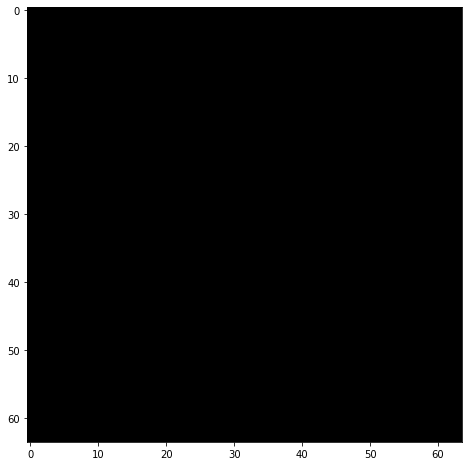

In [197]:
E.update()
f, axs = plt.subplots(1,figsize=(8,8))
axs.imshow(to_plt(E.states).astype(np.uint8))
# with t.no_grad():
#     E.update()
#     f, axs = plt.subplots(1,figsize=(15,15))
#     axs.imshow(to_plt(E.states))
